In [263]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import io

In [264]:
def make_features(data):
    """Функция формирует лаговые признаки для датасета.
    """
    # Создаем порядковый номер
    data['Time'] = np.arange(len(data))
    
    # Создаем лаговые признаки
    lags = [1, 2, 3]
    for lag in lags:
        data[f'lag_{lag}'] = data['Close'].shift(lag)
        
    # Создаем скользящее среднее
    data['rolling_mean_5'] = data['Close'].rolling(window=5).mean()
    
    # Удаляем пропуски
    data.dropna(inplace=True)
    
    return data

In [265]:
# data = make_features(data)
# data

In [266]:
def make_dataset(data):
    """Функция разбивает датасет на тренировочный и тестовый наборы.
    """
    train, test = train_test_split(data, test_size=0.15, shuffle=False)

    return train, test

In [267]:
# train, test = make_dataset(data)
# print(train, test)

In [268]:
def train_models(train, test):
    """Функция тренирует модели и делает предсказания на тестовой выборке
    """
    # Определяем целевую переменную и признаки
    target_col = ['Close']
    feature_cols = [col for col in train.columns if col not in target_col + ['Date']]
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]

    # Модель Random Forest
    print('Обучение модели Random Forest...')
    model_rf = RandomForestRegressor(n_estimators=75, min_samples_leaf=5, max_depth=15, random_state=42)
    model_rf.fit(X_train, y_train.values.ravel())

    # Модель ARIMA
    print('Обучение модели ARIMA...')
    model_arima = ARIMA(y_train.values.ravel(), order=(5,1,2)).fit()

    # Модель LSTM
    print('Обучение модели LSTM...')
    model_lstm = Sequential()
    model_lstm.add(Input(shape=(30, 1)))
    model_lstm.add(LSTM(25, activation='relu'))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mape')

    # Создаем генератор временных рядов
    generator = TimeseriesGenerator(y_train.values.flatten(), y_train.values.flatten(), length=30, batch_size=32)
    model_lstm.fit(generator, epochs=35)

    # Выполняем прогнозы
    y_pred_rf = model_rf.predict(X_test)
    y_pred_arima = model_arima.forecast(len(test))
    y_pred_lstm = []
    last_sequence = y_train.values[-30:]
    for _ in range(len(test)):
        pred = model_lstm.predict(last_sequence.reshape((1, 30, 1)))[0][0]
        y_pred_lstm.append(pred)
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = pred
    y_pred_lstm = np.array(y_pred_lstm)

    return model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm

In [269]:
# model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm = train_models(train, test)

In [270]:
# print(y_pred_rf)
# print()
# print(y_pred_arima)
# print()
# print(y_pred_lstm)
# print()
# print(test['Close'].to_numpy())

In [273]:
def select_best_model(test, model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm):
    """Функция определяет лучшую модель по показателю MAPE.
    """
    # Определяем целевую переменную
    y_test = test['Close']
    
    # Сравнение моделей
    print('Сравнение моделей:')
    print('Оценка модели Random Forest...')
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
    # print(rmse_rf, mape_rf)

    print('Оценка модели ARIMA...')
    rmse_arima = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    mape_arima = mean_absolute_percentage_error(y_test, y_pred_arima)
    # print(rmse_arima, mape_arima)

    print('Оценка модели LSTM...')
    rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
    mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
    # print(rmse_lstm, mape_lstm)

    # Выбор лучшей модели
    print('Выбор лучшей модели...')
    best_model_name = None
    best_model_object = None
    best_rmse = float('inf')
    best_mape = float('inf')

    if mape_rf < best_mape:
        best_model_name = 'Random Forest'
        best_model_object = model_rf
        best_rmse = rmse_rf
        best_mape = mape_rf

    if mape_arima < best_mape:
        best_model_name = 'ARIMA'
        best_model_object = model_arima
        best_rmse = rmse_arima
        best_mape = mape_arima

    if mape_lstm < best_mape:
        best_model_name = 'LSTM'
        best_model_object = model_lstm
        best_rmse = rmse_lstm
        best_mape = mape_lstm

    return best_model_name, best_model_object, best_rmse, best_mape

In [274]:
# best_model_name, best_model_object, best_rmse, best_mape = select_best_model(test, model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm)
# print(best_model_name, best_model_object, best_rmse, best_mape)

In [275]:
def make_forecast(best_model_name, best_model_object, data):
    """Функция генерирует предсказание цен акций выбранной моделью на 30 дней.
    """
    # Генерируем даты
    period=30
    future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=period, freq='D')

    # Генерируем предсказания
    # Модель Random Forest
    if best_model_name == 'Random Forest':
        df_future = pd.DataFrame(index=future_dates)
        df_future['Time'] = np.arange(len(data), len(data)+period)
        for lag in [1, 2, 3]:
            df_future[f'lag_{lag}'] = data['Close'].iloc[-lag]
        df_future['rolling_mean_5'] = data['Close'].iloc[-5:].mean()
        df_future.ffill(inplace=True)
        features = [col for col in df_future.columns if col not in ['Date']]
        future_pred = best_model_object.predict(df_future[features])
    # Модель ARIMA
    elif best_model_name == 'ARIMA':
        future_pred = best_model_object.forecast(steps=period)
    # Модель LSTM
    elif best_model_name == 'LSTM':
        last_sequence = data['Close'].values[period*(-1):]
        lstm_preds = []
        for _ in range(period):
            pred = best_model_object.predict(last_sequence.reshape((1, period, 1)))[0][0]
            lstm_preds.append(pred)
            last_sequence = np.roll(last_sequence, -1)
            last_sequence[-1] = pred
        future_pred = np.array(lstm_preds)

    return future_dates, future_pred

In [276]:
# best_model_name = 'Random Forest'
# best_model_object = model_rf
# best_model_name = 'ARIMA'
# best_model_object = model_arima
# best_model_name = 'LSTM'
# best_model_object = model_lstm

In [277]:
# future_dates, future_pred = make_forecast(best_model_name, best_model_object, data)

In [278]:
# future_pred

In [279]:
# data.info()
# data.head()

In [280]:
def visualize_forecast(data, future_dates, future_pred):
    """Функция визуализирует график исторических данных и предсказания цен на акции.
    """
    # Соединяем точки
    history_end_date = data['Date'].iloc[-1]
    first_future_date = future_dates[0]
    connection_point = [(history_end_date, data['Close'].iloc[-1]), (first_future_date, future_pred[0])]
    conn_x, conn_y = zip(*connection_point)

    # Визуализируем график
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], data['Close'], label='История')
    plt.plot(conn_x, conn_y, color='orange')
    plt.plot(future_dates, future_pred, label='Прогноз')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.title('Прогноз цен акций')
    plt.legend()
    plt.grid(True)

    # Сохраняем график в буфер
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    return buf

In [281]:
# buf = visualize_forecast(data, future_dates, future_pred)

In [285]:
def forecast_pipeline(data):
    """Основная функция, сравнивающая модели, выполняющая прогноз и анализ цен на акции.
    """
    # Создаем лаговые признаки
    data = make_features(data)
    
    # Разбиваем данные на тренировочные и тестовые
    train, test = make_dataset(data)

    # Тренируем модели
    model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm = train_models(train, test)
    
    # Выбираем лучшую модель
    best_model_name, best_model_object, best_rmse, best_mape = select_best_model(test, model_rf, model_arima, model_lstm, y_pred_rf, y_pred_arima, y_pred_lstm)

    # Выполняем прогноз на 30 дней
    future_dates, future_pred = make_forecast(best_model_name, best_model_object, data)

    # Визуализируем график с историей и предсказанием
    buf = visualize_forecast(data, future_dates, future_pred)

    # Анализируем разницу с текущей ценой
    current_price = data['Close'].values[-1]
    future_price = future_pred[-1]
    change = (future_price - current_price) / current_price * 100

    return best_model_name, best_rmse, best_mape, change, buf

In [283]:
ticker='AAPL'
data_raw = yf.download(ticker, period="2y")
data_close = data_raw['Close'][ticker].copy()
data_preprocess = pd.DataFrame(data_close)
data_preprocess['Date'] = data_preprocess.index
data = data_preprocess.reset_index(drop=True)
data = data.rename(columns={ticker: 'Close'})

[*********************100%***********************]  1 of 1 completed


Обучение модели Random Forest...
Обучение модели ARIMA...
Обучение модели LSTM...
Epoch 1/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 111.3030
Epoch 2/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 59.2028
Epoch 3/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 87.9406
Epoch 4/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 141.2204
Epoch 5/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 142.9128
Epoch 6/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 117.5556
Epoch 7/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 125.6578
Epoch 8/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 110.3655
Epoch 9/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 45.5505
Epoch 10/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.3345
Epoch 11/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.6961
Epoch 12/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.7120
Epoch 13/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4733 
Epoch 14/35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

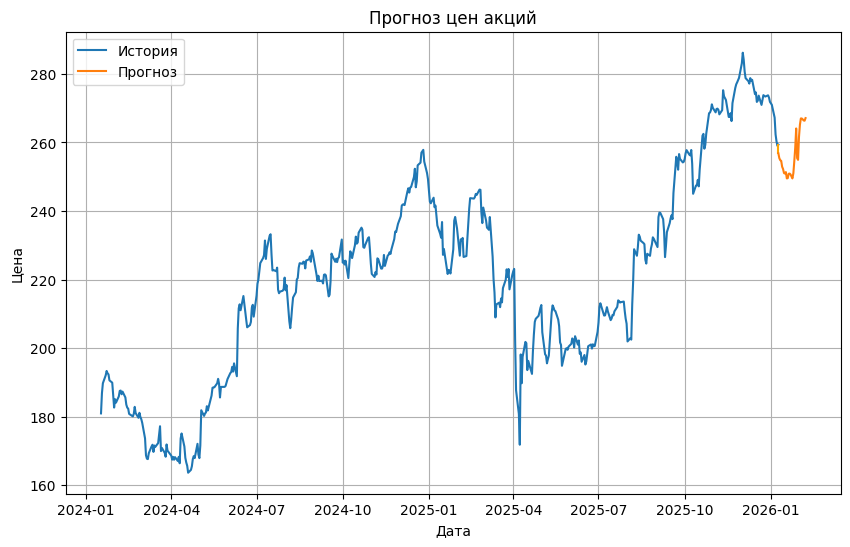

In [284]:
print(forecast_pipeline(data))